In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.otf')
# cmfont = font_manager.FontProperties('/Users/theoares/Library/Fonts/cmunrm.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
mpl.rcParams['axes.formatter.use_mathtext'] = True

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox
from matplotlib import gridspec

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *

In [2]:
cfg_idx = 0
config = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][cfg_idx]
cfg_path = ['24I/ml0p01', '24I/ml0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004'][cfg_idx]
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/SD_output.h5'
n_ops = 5
# colors = [(1., .40, 0), (.80, .60, .70), (0, .45, .90), (0, .60, .50), (.95, .90, .25)]
# style = styles['prd_twocol']

In [3]:
f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['pion-00WW'][()]
C3pt_tavg = f['C3pt'][()]
Cnpt = f['Cnpt'][()]
# R = f['R'][()]
R_boot = f['R'][()]
f.close()
# n_files = Cnpt.shape[0]

In [4]:
# # R_boot = bootstrap(R)
# R_μ = np.mean(R_boot, axis = 0)
# R_σ = np.std(R_boot, axis = 0, ddof = 1)

In [5]:
# # Plot C3(t, 2t) / C2(2t)
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, 2 * t]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, 2 * t]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [6]:
# # Plot C3(t, sep) / C2(sep)
# sep = 21
# data_plot, σ_plot = [], []
# plot_domain = range(T // 2)
# for i in range(n_ops):
#     data_plot.append([np.real(R_μ[i, t, sep]) for t in range(T // 2)])
#     σ_plot.append([np.real(R_σ[i, t, sep]) for t in range(T // 2)])
# data_plot, σ_plot = np.array(data_plot), np.array(σ_plot)

In [7]:
# Try to replicate the plots in 24I/ml_0p01/plots, this is what is generated by plot_pion_0vbb_4quark_ratios.py
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
# data_slice = np.zeros((n_files, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_mu = np.mean(data_slice, axis = 0)
data_plot_sigma = np.std(data_slice, axis = 0, ddof = 1)

In [8]:
# # fit each linear region to a constant by fitting over a region
# fit_regions = [
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26),
#     range(18, 26)
# ]
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
# for i in range(n_ops):
#     fits[:, i] = fit_constant(fit_regions[i], data_slice[:, i])[0]
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

In [9]:
fits = np.zeros((n_boot, n_ops), dtype = np.float64)
f_acc = []
stats_acc = []
R_ens_acc = []
chi2_full = []
weights = []
c = [0, 0, 0, 0, 0]
sigmac = [0, 0, 0, 0, 0]
for i in range(n_ops):
    # results = fit_constant_allrange(data_slice[:, i, : (T // 2)])
    results = fit_const_allrange(data_slice[:, i, : (T // 2)])
    f_acc.append(results[0])
    stats_acc.append(results[1])
    R_ens_acc.append(results[2])
    chi2_full.append(results[3])
    weights.append(results[4])
    c[i], sigmac[i], fits[:, i] = analyze_accepted_fits(results[2], results[4])

Accepted fits:
fit index | fit range | p value | c_fit mean | c_fit sigma | weight 
253 range(11, 15) 0.032040228554217884 -0.005678568868909508 3.534261489742423e-05 25650642.527572032
301 range(14, 18) 0.031132456510769513 -0.005739320199505182 4.007038804814484e-05 19389485.875485547
321 range(15, 25) 0.010983450519717169 -0.005737464220366204 3.348980684863731e-05 9792949.441117804
322 range(15, 26) 0.011691508381296855 -0.005734228613727189 3.3374077196057824e-05 10496681.33992164
333 range(16, 25) 0.012287132192970595 -0.00575478512755363 3.579860108026819e-05 9587787.92210001
334 range(16, 26) 0.01517012646354513 -0.005753683369854498 3.5780830617400496e-05 11849181.861384777
335 range(16, 27) 0.01528946848830517 -0.005743770983321928 3.4843235475234436e-05 12593760.68472266
340 range(17, 21) 0.024128973520180324 -0.005745769289642413 4.1017506462974454e-05 14341690.183700897
341 range(17, 22) 0.04893649253406021 -0.005748361684217662 4.028934519372132e-05 30147577.516871363
342

362 range(19, 24) 0.29775870210421124 -0.009916011321255969 8.618964241284457e-05 40082454.196437635
363 range(19, 25) 0.27877913854077213 -0.009934609600488505 8.47369527382061e-05 38825279.203439094
364 range(19, 26) 0.05971508566122119 -0.009874647934876692 8.100332406021025e-05 9100775.005908003
365 range(19, 27) 0.021155418645994177 -0.009876122487848969 8.100024991483457e-05 3224399.954592444
368 range(19, 30) 0.011600562582061172 -0.009898066662223537 7.840620707751573e-05 1887027.2026720517
369 range(19, 31) 0.01828963447782541 -0.009907064848194515 7.388921285146907e-05 3349985.645301737
370 range(20, 24) 0.7248699084474075 -0.009977712032866445 9.21497827881283e-05 85363347.90218866
371 range(20, 25) 0.6664473239963169 -0.009996496931120204 9.032701054204428e-05 81682788.30322285
372 range(20, 26) 0.23802583032678962 -0.009954462256685575 8.807337627829855e-05 30685612.630149722
373 range(20, 27) 0.19777709717700315 -0.009968606244941718 8.744699983680771e-05 25863432.9607194

311 range(14, 28) 0.0696068830752726 0.0003417477052996487 1.348047492242289e-06 38303794722.834496
312 range(14, 29) 0.05544208113979226 0.0003420191465667788 1.335194268754124e-06 31099299378.56797
313 range(14, 30) 0.06096542974698412 0.00034260946702997953 1.1886758946994027e-06 43147608363.35896
314 range(14, 31) 0.0366208484766808 0.00034293098521079204 1.1750614376197359e-06 26522060055.269505
315 range(15, 19) 0.18118021969224943 0.0003439387499006519 1.7580962275914608e-06 58617257823.66043
316 range(15, 20) 0.13810377961090922 0.00034290900622957254 1.6068383270195366e-06 53488596210.23736
317 range(15, 21) 0.11386176538601782 0.00034327258721936096 1.5853111583553345e-06 45305286403.183334
318 range(15, 22) 0.1786078291496489 0.00034331168812737236 1.5689318080679122e-06 72559178360.9805
319 range(15, 23) 0.25682323167918764 0.00034337757759741463 1.523157290829959e-06 110699280778.13802
320 range(15, 24) 0.09868945238256736 0.00034254085351646867 1.4707436026704814e-06 4562

393 range(23, 29) 0.5077769625689823 0.0003446225447539986 1.968563014280691e-06 131031089135.63458
394 range(23, 30) 0.5142833756978114 0.00034533891990047306 1.8243375735731352e-06 154522626060.05267
395 range(23, 31) 0.600519053196705 0.0003456233279129783 1.73552278938059e-06 199372910817.50656
396 range(24, 28) 0.6041930688008021 0.00034525811975327114 2.0333739283924136e-06 146130623466.93195
397 range(24, 29) 0.731192149570078 0.0003453363441356405 2.0247669803807207e-06 178353411310.2324
398 range(24, 30) 0.5044366551017425 0.0003460482703345291 1.9694599927604095e-06 130050585305.6849
399 range(24, 31) 0.5890270250185166 0.00034633924033939946 1.9039815171135095e-06 162483686772.04297
400 range(25, 29) 0.9381355430480564 0.0003466271449428993 2.2652982931008153e-06 182816249400.34882
401 range(25, 30) 0.9152714190869216 0.0003472897879573766 2.082813550789216e-06 210983800893.21732
402 range(25, 31) 0.9401945371943918 0.0003475670258360153 2.0168941440040844e-06 231127442361.7

344 range(17, 25) 0.06158312906948614 0.002396512661927395 1.7450181527019555e-05 202237577.12504444
345 range(17, 26) 0.05397258104598568 0.0023957719285582968 1.744151035102909e-05 177420993.59701297
346 range(17, 27) 0.015552966487494647 0.0023944163471962925 1.743124072708252e-05 51186641.48299379
351 range(18, 22) 0.31589173523871045 0.0024199312471096814 2.1993596446345693e-05 653048985.8797301
352 range(18, 23) 0.4702660343698899 0.0024207283495380548 2.0808839915840855e-05 1086045133.8813088
353 range(18, 24) 0.34552606327904034 0.0024170595617619317 2.0651581971895923e-05 810166275.6584427
354 range(18, 25) 0.272795778631977 0.002421963250372543 2.034883784517038e-05 658807331.4836978
355 range(18, 26) 0.055242000073543046 0.0024058932317600258 1.9303050276974707e-05 148257786.034303
356 range(18, 27) 0.01779635711500696 0.002405881497586484 1.930304950428043e-05 47761643.55140192
361 range(19, 23) 0.38184107958215396 0.0024223420685801746 2.0937141371683338e-05 871059613.5367

In [10]:
# order 1, 2, 3, 1p, 2p
print(config)
for i in range(n_ops):
    print(latex_labels[i] + ': ' + str(c[i]) + ' \pm ' + str(sigmac[i]))

24I/ml_0p01
O_1: -0.005790385736119443 \pm 4.703728894056271e-05
O_2: -0.009978939713065085 \pm 0.00010916435216080551
O_3: 0.0003444616276936548 \pm 2.395090605754748e-06
O_{1'}: -0.0178915981036925 \pm 0.00014879818096616787
O_{2'}: 0.002433994258011261 \pm 2.6209134087096518e-05


## Make plots

/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_56673/826080714.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(0, 31, 5), fontdict = {'fontsize' : style['fontsize'] * 2/3})
/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_56673/826080714.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ytick_str, fontdict = {'fontsize' : style['fontsize'] * 2/3})
/var/folders/q2/tk_jvj_106gddw96ph0kg7r40000gn/T/ipykernel_56673/826080714.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saving figure


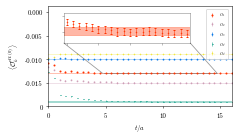

In [11]:
style = styles['prd_twocol']
box_alpha = 0.5
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)
with sns.plotting_context('paper'):
    #asp_ratio = 4./3.
    #asp_ratio = 3./2.
    asp_ratio = 5/3
    fig, ax = plt.subplots(figsize=[style['colwidth'], style['colwidth'] / asp_ratio])
    for i in range(n_ops):
        ax.errorbar(plot_domain, data_plot_mu[i], yerr = data_plot_sigma[i], fmt = markers[i], c = colors[i], \
                    label = '$' + latex_labels[i] + '$', elinewidth = style['ebar_width'], markersize = style['markersize'])
        ax.fill_between(plot_domain, c[i] - sigmac[i], c[i] + sigmac[i], color = colors[i], alpha = 0.3)
    ax.set_xlabel('$t / a$', fontsize = style['fontsize'] * 2/3)
    ax.set_ylabel('$\\langle \mathcal{O}_k^{\mathrm{eff.}(0)} \\rangle$', fontsize = style['fontsize'] * 2/3)#, rotation = 0)
    #ax.xaxis.set_label_coords(1.1, 0.1)
    #ax.yaxis.set_label_coords(0., 1.1)
    ax.set_xlim((0, T // 2))
    ax.set_ylim((-0.16 / 8., 0.18 / 8.))
    #ax.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))    # y axis sci notation
    ax.set_xticklabels(np.arange(0, 31, 5), fontdict = {'fontsize' : style['fontsize'] * 2/3})
    yticks = safe_arange(-0.015, 0.016, 0.005)
    ytick_str = ['0']
    for ii in range(len(yticks)):
        ytick_str.append("{:.3f}".format(yticks[ii]))
    ax.set_yticklabels(ytick_str, fontdict = {'fontsize' : style['fontsize'] * 2/3})
    ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    for spine in spinedirs:
        ax.spines[spine].set_linewidth(style['axeswidth'])
    ax.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', prop={'size': style['fontsize'] * 0.4})
    
    # create inset axes
    axins = inset_axes(ax, width="30%", height="30%", loc='upper left',
                       bbox_to_anchor=(0.06, -0.02, 2.3, 1.), bbox_transform=ax.transAxes)
    
    for spine in spinedirs:
        axins.spines[spine].set_alpha(box_alpha)
        axins.spines[spine].set_linewidth(style['axeswidth'])
    axins.tick_params(axis='x', color = [0, 0, 0, box_alpha])
    axins.tick_params(axis='y', color = [0, 0, 0, box_alpha])
    for i in range(n_ops):
        axins.errorbar(plot_domain, data_plot_mu[i], yerr = data_plot_sigma[i], fmt = '.', c = colors[i], \
                       label = '$' + latex_labels[i] + '$', capsize = style['endcaps'], \
                       elinewidth = style['ebar_width'], markersize = style['markersize'])
        axins.fill_between(plot_domain, c[i] - sigmac[i], c[i] + sigmac[i], color = colors[i], alpha = 0.35)
    # axins.set_xlim((6.5, 31.5))
    # axins.set_ylim((-0.048 / 8., -0.044 / 8.))
    axins.set_xlim((9.5, 29.5))
    #axins.set_ylim((-0.049 / 8., -0.044 / 8.))
    axins.set_ylim((-0.0475 / 8., -0.0445 / 8.))
    axins.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    axins.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    plt.xticks(visible = False)
    plt.yticks(visible = False)
    axins.set_facecolor('none')
    #axins.indicate_inset((0.1, -0.04, 2.55, 1), edgecolor = '1')

    # This sets the smaller bounding box on the data, ec allows you to set the color
    #mark_inset(ax, axins, loc1 = 3, loc2 = 4, fc = 'none', ec='0.2', alpha = 1)
    mark_inset(ax, axins, loc1 = 3, loc2 = 4, fc = 'none', ec='0.2', alpha = box_alpha)

    plt.draw()
    plt.tight_layout()
    if cfg_idx == 0:
        print('Saving figure')
        plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/24Iml0p01_fits.pdf', bbox_inches='tight')
    plt.show()

In [12]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/plots/24I/ml_0p01/24Iml0p01_fits.pdf')

In [13]:
# # Large appendix figures-- need to scale down
# efflabels = ['$\\langle ' + label + '^{\mathrm{eff. (0)}} \\rangle$' for label in latex_labels]
# yrange = [
#     [[-0.05, -0.038], [-0.085, -0.065], [0.0026, 0.0032], [-0.118, -0.15], [0.0165, 0.021]], 
#     [[-0.041, -0.034], [-0.07, -0.058], [0.0013, 0.0017], [-0.125, -0.1070], [0.0144, 0.0171]], 
#     [[-0.0155, -0.0120], [-0.024, -0.019], [0.000625, 0.00080], [-0.05, -0.036], [0.0046, 0.0062]], 
#     [[-0.0136, -0.0112], [-0.0215, -0.0180], [0.00043, 0.00055], [-0.043, -0.034], [0.0045, 0.0055]], 
#     [[-0.01225, -0.01025], [-0.0195, -0.0165], [0.00026, 0.00035], [-0.039, -0.032], [0.0041, 0.0048]]
# ][cfg_idx]
# for i in range(n_ops):
#     with sns.plotting_context('paper'):
#         plt.figure(figsize = (10, 6))
#         plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_sigma[i], fmt = '.', c = 'r', label = efflabels[i], capsize = 2)
#         plt.fill_between(plot_domain, c[i] - sigmac[i], c[i] + sigmac[i], color = 'b', alpha = 0.2)
#         plt.title(efflabels[i] + ' on ensemble ' + cfg_path, fontsize = 18)
#         plt.xlabel('$t / a$', fontsize = 18)
#         plt.ylabel(efflabels[i], fontsize = 18)
#         plt.xticks(fontsize = 18)
#         plt.yticks(fontsize = 18)
#         plt.xlim((0, T // 2 + 0.5))
#         plt.ylim(yrange[i][0] / 8., yrange[i][1] / 8.)
#         plt.tight_layout()
#         plt.show()

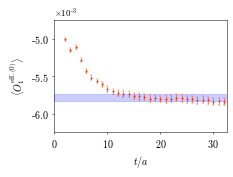

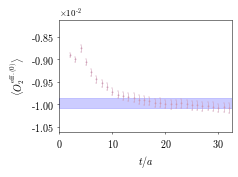

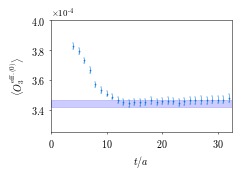

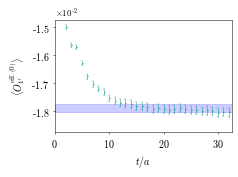

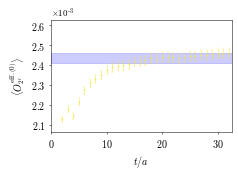

In [14]:
# iterate over fit ranges and save figure
# efflabels = ['$\\langle ' + label + '^{\mathrm{eff. (0)}} \\rangle$' for label in latex_labels]
efflabels = ['$\\langle ' + label + '^{\mathrm{eff. (0)}} \\rangle$' for label in latex_labels]
yrange = [
    [[-0.05, -0.038], [-0.085, -0.065], [0.0026, 0.0032], [-0.15, -0.118], [0.0165, 0.021]], 
    [[-0.041, -0.034], [-0.07, -0.058], [0.0013, 0.0017], [-0.125, -0.1070], [0.0144, 0.0171]], 
    [[-0.0155, -0.0120], [-0.024, -0.019], [0.000625, 0.00080], [-0.05, -0.036], [0.0046, 0.0062]], 
    [[-0.0136, -0.0112], [-0.0215, -0.0180], [0.00043, 0.00055], [-0.043, -0.034], [0.0045, 0.0055]], 
    [[-0.01225, -0.01025], [-0.0195, -0.0165], [0.00026, 0.00035], [-0.039, -0.032], [0.0041, 0.0048]]
][cfg_idx]
style = styles['prd_twocol']
asp_ratio = 4/3
# asp_ratio = 5/3
fig_size = (style['colwidth'], style['colwidth'] / asp_ratio)
for i in range(n_ops):
    with sns.plotting_context('paper'):
        plt.figure(figsize = fig_size)
        _, caps, _ = plt.errorbar(plot_domain, data_plot_mu[i], yerr = data_plot_sigma[i], fmt = markers[i], c = colors[i], \
                     label = efflabels[i], capsize = style['endcaps'], markersize = style['markersize'], \
                     elinewidth = style['ebar_width'])
        plt.fill_between(plot_domain, c[i] - sigmac[i], c[i] + sigmac[i], color = 'b', alpha = 0.2)
        for cap in caps:
            cap.set_markeredgewidth(style['ecap_width'])
        plt.xlabel('$t / a$', fontsize = style['fontsize'])
        plt.ylabel(efflabels[i], fontsize = style['fontsize'])
        ax = plt.gca()
        ax.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        ax.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
        for spine in spinedirs:
            ax.spines[spine].set_linewidth(style['axeswidth'])
        plt.xticks(fontsize = style['fontsize'])
        plt.yticks(fontsize = style['fontsize'])
        plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))    # y axis sci notation
        plt.xlim((0, T // 2 + 0.5))
        plt.ylim(yrange[i][0] / 8., yrange[i][1] / 8.)
        plt.tight_layout()
        plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/bare_eff_mat_elems/' + cfg_path + '/' + op_labels[i] + '.pdf', bbox_inches='tight')
        plt.show()

#### Stack subfigures on top of each other

In [62]:
ytick_labels = [['-6.0', '-5.4', '-4.8'], ['-1.0', '-0.9', '-0.8'], ['3.2', '3.6', '4.0'], ['-1.8', '-1.6', '-1.4'], ['2.2', '2.4', '2.6']]
pwr = [-3, -2, -4, -2, -3]
ytick_locs = [[round(float(ytick_labels[k][i]) * (10 ** pwr[k]), np.abs(pwr[k]) + 2) for i in range(len(ytick_labels[k]))] for k in range(n_ops)]
efflabels = ['$' + latex_labels[ii] + '^{\mathrm{eff.}}\\times 10^{' + str(pwr[ii]) + '}$' for ii in range(len(latex_labels))]

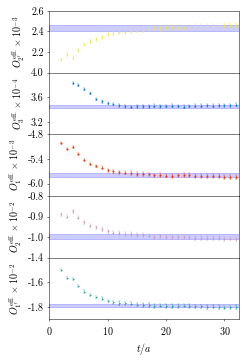

In [67]:
yrangep = [[-0.0063, -0.0048], [-0.011, -0.008], [0.0003, 0.0004], [-0.019, -0.014], [0.0020, 0.0026]]
reindex = [4, 2, 0, 1, 3]
asp_ratio = 3.
fig = plt.figure(figsize = (style['colwidth'], style['colwidth'] / asp_ratio * n_ops))
gs = gridspec.GridSpec(n_ops, 1)
all_axes = []#[0] * n_ops
# for i in range(n_ops):
for j in range(n_ops):
    i = reindex[j]
    if j == 0:
        axi = plt.subplot(gs[j])
    else:
        axi = plt.subplot(gs[j], sharex = all_axes[0])
    _, caps, _ = axi.errorbar(plot_domain, data_plot_mu[i], yerr = data_plot_sigma[i], fmt = markers[i], c = colors[i],\
                         label = efflabels[i], capsize = style['endcaps'], markersize = style['markersize'], \
                         elinewidth = style['ebar_width'])
    axi.fill_between(plot_domain, c[i] - sigmac[i], c[i] + sigmac[i], color = 'b', alpha = 0.2)
    for cap in caps:
        cap.set_markeredgewidth(style['ecap_width'])
    #axi.set_ylim((yrange[i][0] / 8., yrange[i][1] / 8.))
    for spine in spinedirs:
        axi.spines[spine].set_linewidth(style['axeswidth'])
    axi.set_ylim((yrangep[i][0], yrangep[i][1]))
    axi.set_ylabel(efflabels[i], fontsize = style['fontsize'])
    axi.xaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    axi.yaxis.set_tick_params(width = style['tickwidth'], length = style['ticklength'])
    axi.set_yticks(ytick_locs[i])
    axi.set_yticklabels(ytick_labels[i])
    #axi.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
    all_axes.append(axi)
all_axes[4].set_xlim((0, T // 2 + 0.5))
all_axes[4].set_xlabel('$t / a$', fontsize = style['fontsize'])
# from matplotlib.ticker import MaxNLocator
# for ii in range(n_ops):
#     all_axes[ii].yaxis.set_major_locator(MaxNLocator(nbins = 3, prune = 'lower'))
for i in range(n_ops - 1):
    plt.setp(all_axes[i].get_xticklabels(), visible=False)

# remove vertical gap between subplots
plt.subplots_adjust(hspace = 0.0)
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/paper/plots/24Iml0p01_fits_stacked.pdf',bbox_inches='tight')
plt.show()

## Save data to file

In [16]:
# out_file = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/bare_matrix_elements/' + config + '/fit_params.h5'
# fout = h5py.File(out_file, 'w')
# fout['fits'] = fits
# fout.close()